# Machine/Deep Learning Models

## Data Cleaning

In [0]:
#!pip install translate
import os
import re
import csv
import sys
import numpy as np
import pandas as pd
import spacy
import operator
import nltk
import multiprocessing as mp
from translate import Translator
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from collections import defaultdict
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
train = pd.read_csv("train.csv")

In [0]:
stop_words = stopwords.words('english')
def clean_text(text):
    text = text.lower()
    # Removed url links and ip addresses
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)
    
    text = " ".join([w for w in text.split() if w not in stop_words])
    
    # Clean typo(NOT misspelling)
    #for typo, correct in clean_word_dict.items():
    #    text = re.sub(typo, " " + correct + " ", text)

    # Clean other words
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"&", "and", text)
    text = re.sub(r"@", "at", text)
    # Replaced words that have a special symbol in between them 
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\?", " ", text)
    text = re.sub(r"\!", " ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Replace numbers with language
    text = text.replace('0', ' zero ')
    text = text.replace('1', ' one ')
    text = text.replace('2', ' two ')
    text = text.replace('3', ' three ')
    text = text.replace('4', ' four ')
    text = text.replace('5', ' five ')
    text = text.replace('6', ' six ')
    text = text.replace('7', ' seven ')
    text = text.replace('8', ' eight ')
    text = text.replace('9', ' nine ')
    
    # Drop the image
    text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", text)
    text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", text)

    # Drop CSS
    text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",text)
    text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
        
    # Clean templates
    text = re.sub(r"\[?\[user:.*\]", " ", text)
    text = re.sub(r"\[?\[user:.*\|", " ", text)        
    text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
    text = re.sub(r"\[?\[wikipedia:.*\|", " ", text)
    text = re.sub(r"\[?\[special:.*\]", " ", text)
    text = re.sub(r"\[?\[special:.*\|", " ", text)
    text = re.sub(r"\[?\[category:.*\]", " ", text)
    text = re.sub(r"\[?\[category:.*\|", " ", text)
    
    return (text)

In [0]:
train['comment_text'] = train['comment_text'].apply(clean_text)

In [0]:
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  explanation edits made username hardcore metal...      0   
1  000103f0d9cfb60f  d aww matches background colour i am seemingly...      0   
2  000113f07ec002fd  hey man i am really trying edit war guy consta...      0   
3  0001b41b1c6bb37e   cannot make real suggestions improvement wond...      0   
4  0001d958c54c6e35         you sir hero chance remember page that on       0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

## Embedding Visulaization

In [0]:
from nltk.tokenize import word_tokenize
import gensim
import numpy as np
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import plotly.offline as plt
import plotly.graph_objs as go
plt.init_notebook_mode(connected=True)

In [0]:
comments = train.comment_text.str.cat(sep=' ')
tokens = word_tokenize(comments)

In [0]:
vocabulary = set(tokens)

In [0]:
print(len(vocabulary))

177390


In [0]:
#Top n words
frequency_dist = nltk.FreqDist(vocabulary)
top_30000 = sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:30000]

In [0]:
#print(top_100)

['ramble', 'intensifies', 'discerned', 'diadem', 'stopzilla', 'mercia', 'koloo', 'ɾ', 'celtus', 'reincarnated', 'azerbaijanis', 'besieged', 'vaida', 'jenks', 'episiotomy', 'unblocing', 'ourcampaigns', 'plagiarizers', 'dateofbirth', 'curbs', 'tcpdump', 'opulebnce', 'relata_refero', 'ŋ', 'receiving', 'wrenching', 'arrius', 'anthere', 'dualities', 'gaya', 'keyless', 'everying', 'pbjc', 'f*k', 'behistun', 'contemporarity', 'recrfa', 'judaizing', 'absences', 'prizes', 'denise|u', 'didn', 'blinly', 'hypertwrt', 'almendares', 'greenberg', 'disproof', 'sagawa', '|year', 'unauthenticated', 'plaza', 'halarious', 'piloted', 'patan', 'tankman', 'caboolture', 'excitably', 'golomb', 'josuquis', 'dzierzon', 'dmartinaus', 'differentiating', '_hjszandsig', 'shari', '_anonymous_crusher', 'shitfucker', 'friedwardt', 'pothos', 'appologist', 'scherzingertabg', 'pagethan', 'ashmoo', 'beara', 'xhtml', 'tunnelvision', 'soaking', 'philosopher', 'melody', 'transsexualism', 'familiar', 'irresistable', 'tengri', 

In [0]:
#!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [0]:
def get_coordinates(model, words):
    arr = np.empty((0,300), dtype='f')
    labels = []
    #i=1
    for wrd_score in words:
     #   i=i+1
     #   print(i)
        try:
            wrd_vector = model[wrd_score]
            arr = np.append(arr, np.array([wrd_vector]), axis=0)
            labels.append(wrd_score)
        except:
            pass
    tsne = TSNE(n_components=2, n_iter=1000)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    return Y

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


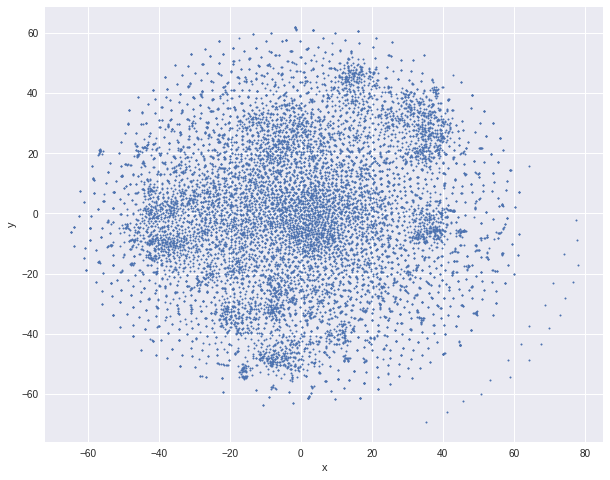

In [0]:
X_2d = get_coordinates(w2v_model, top_30000)

cord_df= pd.DataFrame(X_2d,  columns=['x','y'])
cord_df.plot.scatter('x', 'y', figsize=(10,8), marker='.', s=10, alpha=1.0)

In [0]:
cord_df.head()

x           y
0   80.296432 -252.484558
1    8.005713  241.228790
2  137.302521   51.530720
3  236.327072  -40.438484
4  -52.720840  114.916656

## Bi-LSTM with Google Word2Vec embeddings

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip GoogleNews-vectors-negative300.bin

--2019-04-02 11:12:31--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.131.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.131.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  42.1MB/s    in 31s     

2019-04-02 11:13:02 (51.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
import os
import re
import csv

import numpy as np
import pandas as pd

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D, SpatialDropout1D
from keras.layers import GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [0]:
train_data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [0]:
test_data.head()

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

In [0]:
train_data_model = train_data.iloc[:,1:]
test_data_model = test_data.iloc[:,1:]

In [0]:
embedding_file = 'GoogleNews-vectors-negative300.bin'
max_sequence_length = 100
embedding_dim = 300
#max_features = 30000
validation_split = 0.2

In [0]:
np.random.seed(26)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
print(num_dense)

106


In [0]:
train_comments = train_data_model["comment_text"].fillna("_na_").values
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_data_model[classes].values
test_comments = test_data_model["comment_text"].fillna("_na_").values

In [0]:
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)
tokenizer.fit_on_texts(list(train_comments))
tokenized_train = tokenizer.texts_to_sequences(train_comments)
tokenized_test = tokenizer.texts_to_sequences(test_comments)
X_t = pad_sequences(tokenized_train, maxlen=max_sequence_length, padding='post', truncating='post')

In [0]:
train_samples = train_comments.size
print(train_samples)

159571


In [0]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

210338


In [0]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [0]:
word2vec = KeyedVectors.load_word2vec_format(embedding_file, binary=True)

In [0]:
word_index = tokenizer.word_index
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_vector = word2vec.word_vec(word)
        if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(210338, 300)

In [0]:
def model_setup(alpha):
  num_lstm = int((train_samples)/(alpha*(embedding_dim+num_dense)))
  inp = Input(shape=(max_sequence_length,))
  x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(inp)
  x = Bidirectional(LSTM(num_lstm, return_sequences=True, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(num_dense, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(6, activation="sigmoid")(x)
  model_blstm_w2vec = Model(inputs=inp, outputs=x)
  model_blstm_w2vec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model_blstm_w2vec
  #print(model_blstm_w2vec.summary())

In [0]:
alpha = [2,3,4,5,6]
models_blstm_w2vec = [None]*5
for i in alpha:
  models_blstm_w2vec[i-2] = model_setup(i)
  models_blstm_w2vec[i-2].fit(x=X_t,y=y,batch_size=256,epochs=2,validation_split=validation_split,verbose=2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 305s - loss: 0.0772 - acc: 0.9755 - val_loss: 0.0537 - val_acc: 0.9810
Epoch 2/2
 - 302s - loss: 0.0514 - acc: 0.9814 - val_loss: 0.0494 - val_acc: 0.9822
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 303s - loss: 0.0874 - acc: 0.9727 - val_loss: 0.0541 - val_acc: 0.9808
Epoch 2/2
 - 298s - loss: 0.0520 - acc: 0.9814 - val_loss: 0.0508 - val_acc: 0.9819
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 303s - loss: 0.0879 - acc: 0.9720 - val_loss: 0.0544 - val_acc: 0.9806
Epoch 2/2
 - 300s - loss: 0.0519 - acc: 0.9811 - val_loss: 0.0494 - val_acc: 0.9821
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 299s - loss: 0.0926 - acc: 0.9716 - val_loss: 0.0542 - val_acc: 0.9806
Epoch 2/2
 - 290s - loss: 0.0530 - acc: 0.9810 - val_loss: 0.0511 - val_acc: 0.9818
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 306s - loss: 0.0931 - acc: 0.9715 - val_loss: 0.0553 - val_a

Training set accuracy - **0.9814**

Validation set accuracy - **0.9822**

In [0]:
#Best model
best_blstm_w2vec_model = models_blstm_w2vec[0]
print(best_blstm_w2vec_model.summary())
best_blstm_w2vec_model.save('Bidirectional_LSTM_Google_W2Vec.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 100, 300)          63101400  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 100, 392)          779296    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 392)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 106)               41658     
_________________________________________________________________
dropout_12 (Dropout)         (None, 106)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 642       
Total para

## Bi-GRU with Google Word2Vec embeddings

In [0]:
def model_setup_gru(alpha):
  num_gru = int((train_samples)/(alpha*(embedding_dim+6)))
  inp = Input(shape=(max_sequence_length, ))
  x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(inp)
  x = SpatialDropout1D(0.2)(x)
  x = Bidirectional(GRU(num_gru, return_sequences=True))(x)
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  outp = Dense(6, activation="sigmoid")(conc)
    
  model_gru_w2vec = Model(inputs=inp, outputs=outp)
  model_gru_w2vec.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  #print(model_gru_w2vec.summary())
  return model_gru_w2vec

In [0]:
alpha = [1,2,3,4,5]
models_gru_w2vec = [None]*5
for i in alpha:
  models_gru_w2vec[i-1] = model_setup_gru(i)
  models_gru_w2vec[i-1].fit(x=X_t,y=y,batch_size=256,epochs=2,validation_split=validation_split,verbose=2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 344s - loss: 0.0692 - acc: 0.9768 - val_loss: 0.0537 - val_acc: 0.9809
Epoch 2/2
 - 338s - loss: 0.0487 - acc: 0.9821 - val_loss: 0.0480 - val_acc: 0.9826
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 235s - loss: 0.0741 - acc: 0.9751 - val_loss: 0.0523 - val_acc: 0.9813
Epoch 2/2
 - 225s - loss: 0.0494 - acc: 0.9819 - val_loss: 0.0492 - val_acc: 0.9819
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 222s - loss: 0.0789 - acc: 0.9749 - val_loss: 0.0523 - val_acc: 0.9815
Epoch 2/2
 - 214s - loss: 0.0502 - acc: 0.9817 - val_loss: 0.0491 - val_acc: 0.9824
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 222s - loss: 0.0815 - acc: 0.9747 - val_loss: 0.0529 - val_acc: 0.9810
Epoch 2/2
 - 214s - loss: 0.0512 - acc: 0.9814 - val_loss: 0.0492 - val_acc: 0.9821
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
 - 217s - loss: 0.0850 - acc: 0.9734 - val_loss: 0.0551 - val_a

Training set accuracy - **0.9821**

Validation set accuracy - **0.9826**

In [0]:
#Best model
best_bgru_w2vec_model = models_gru_w2vec[0]
print(best_bgru_w2vec_model.summary())
best_bgru_w2vec_model.save('Bidirectional_GRU_Google_W2Vec.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 100, 300)     63101400    input_19[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 100, 300)     0           embedding_19[0][0]               
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 100, 1042)    2569572     spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
global_ave

## Bi-LSTM with Glove embeddings

**Training Accuracy  - 0.9842**    
**Validation Accuracy - 0.9838**

In [0]:
import pandas as pd
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')

In [0]:
#Import required packages and Libraries
import sys, os
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers import Embedding,GlobalAveragePooling1D,GlobalMaxPooling1D,MaxPooling1D,GlobalMaxPool1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional,Input,LSTM,Dropout,SpatialDropout1D,RepeatVector,TimeDistributed,Activation
from keras.layers import CuDNNLSTM,CuDNNGRU,Conv1D
from keras.optimizers import Adam
from keras.models import Model

Using TensorFlow backend.


In [0]:
# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

In [0]:
list_sentences_train = train_df["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values

In [0]:
# Fit and run tokenizer
tokenizer.fit_on_texts(list(list_sentences_train))
tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

#Declare params
embed_size = 300 # how big is each word vector
max_features= vocab_size
maxlen = max_len # max number of words in a comment to use

Vocab size: 210337
Longest comment size: 1403
Average comment size: 68.22156908210138
Stdev of comment size: 101.07344657013672
Max comment size: 371



In [0]:
#Apply pad sequence
X_t = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')

In [0]:
import io
print('Indexing word vectors.')
embeddings_index = {}
with io.open('glove.6B.300d.txt', encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features + 1, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_glove = Model(inputs=inp, outputs=x)
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model_glove.summary()
model_glove.fit(X_t, y, batch_size=256, epochs=2, validation_split=0.2);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 371)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 371, 300)          63101400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 371, 512)          1142784   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total para

## Bi-LSTM with Fastext embeddings

**Training Accuracy  - 0.9852**    
**Validation Accuracy - 0.9844**

In [0]:
import io
print('Indexing Fastext word vectors.')
fastext_embeddings_index = {}
with io.open('crawl-300d-2M.vec', encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fastext_embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(fastext_embeddings_index))

Indexing Fastext word vectors.
Found 2000000 word vectors.


In [0]:
embedding_matrix_fastext = np.zeros((len(word_index) + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector_fastext = fastext_embeddings_index.get(word)
    if embedding_vector_fastext is not None: embedding_matrix_fastext[i] = embedding_vector_fastext

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features+1, embed_size, weights=[embedding_matrix_fastext])(inp)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_fastext = Model(inputs=inp, outputs=x)
model_fastext.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_fastext.summary()
model_fastext.fit(X_t, y, batch_size=256, epochs=2, validation_split=0.2);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 371)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 371, 300)          63101400  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 371, 512)          1142784   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
Total para

## Bi-LSTM  + Attention Layer with Fastext embeddings

**Training Accuracy  - 0.9835**    
**Validation Accuracy - 0.9831**

**Our Model accuracy didnot improve after adding the Attention Layer**

In [0]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)
        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features+1, embed_size, weights=[embedding_matrix_fastext])(inp)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = Attention(maxlen)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_attention_fastext = Model(inputs=inp, outputs=x)
model_attention_fastext.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_attention_fastext.summary()
model_attention_fastext.fit(X_t, y, batch_size=256, epochs=2, validation_split=0.2);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 371)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 371, 300)          63101400  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 371, 512)          1142784   
_________________________________________________________________
attention_1 (Attention)      (None, 512)               883       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total para

## CNN with Fastext embeddings

**Training Accuracy  - 0.9846**    
**Validation Accuracy - 0.9835**

In [0]:
model_cnn_fastext = Sequential()
model_cnn_fastext.add(Embedding(max_features+1, embed_size, weights=[embedding_matrix_fastext], input_length=maxlen, trainable=True))
model_cnn_fastext.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model_cnn_fastext.add(MaxPooling1D(3))
model_cnn_fastext.add(GlobalMaxPool1D())
model_cnn_fastext.add(BatchNormalization())
# Add fully connected layers
model_cnn_fastext.add(Dense(50, activation='relu'))
model_cnn_fastext.add(Dropout(0.3))
model_cnn_fastext.add(Dense(6, activation='sigmoid'))
model_cnn_fastext.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_cnn_fastext.summary()
model_cnn_fastext.fit(X_t, y, batch_size=256, epochs=2, validation_split=0.2);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 371, 300)          63101400  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 371, 128)          192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 123, 128)          0         
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 50)                6450      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
__________

## Pooled GRU with Fastext embeddings

**Training Accuracy  - 0.9845**    
**Validation Accuracy - 0.9836**

In [0]:
np = Input(shape=(maxlen, ))
x = Embedding(max_features+1, embed_size, weights=[embedding_matrix_fastext])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(6, activation="sigmoid")(conc)
model_gru_fastext = Model(inputs=inp, outputs=outp)
model_gru_fastext.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model_gru_fastext.summary()
model_gru_fastext.fit(X_t, y, batch_size=256, epochs=2, validation_split=0.2);

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 371)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 371, 300)     63101400    input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 371, 300)     0           embedding_6[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 371, 256)     330240      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

##Stacked Model
###Pooled-GRU + CNN + Bi-LSTM using Fastext Embeddings 

**Training Accuracy  - 0.9835**    
**Validation Accuracy - 0.9839**

In [0]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features+1, embed_size, weights = [embedding_matrix_fastext], trainable = False)(inp)
x1 = SpatialDropout1D(0.2)(x)
x = Bidirectional(CuDNNGRU(128, return_sequences = True))(x1)
x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)    
y1 = Bidirectional(CuDNNLSTM(128, return_sequences = True))(x1)
y1 = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y1)    
avg_pool1 = GlobalAveragePooling1D()(x)
max_pool1 = GlobalMaxPooling1D()(x)
avg_pool2 = GlobalAveragePooling1D()(y1)
max_pool2 = GlobalMaxPooling1D()(y1)
x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])
x = Dense(6, activation = "sigmoid")(x)
model_combined = Model(inputs = inp, outputs = x)
model_combined.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 1e-3, decay = 0), metrics = ["accuracy"])

In [0]:
model_combined.summary()
model_combined.fit(X_t, y, batch_size = 256, epochs = 2, validation_split=0.2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 371)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 371, 300)     63101400    input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 371, 300)     0           embedding_7[0][0]                
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 371, 256)     330240      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
bidirectio

##Analysis

###Fastext Embedding gives better accuracy when compared to 'Word2Vec' and 'Glove'
###Bi-LSTM model using Fastext Embedding has the best accuracy in terms of Both Training and Validation set
###5-Fold CV is performed to test model robustness

![Cross Validation Result](https://ibb.co/qW6BcBw)

In [0]:
def create_model():
  inp = Input(shape=(maxlen,))
  x = Embedding(max_features+1, embed_size, weights=[embedding_matrix_fastext])(inp)
  x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(6, activation="sigmoid")(x)
  best_model = Model(inputs=inp, outputs=x)
  best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return best_model


def train_and_evaluate(model_best, xtrain, ytrain, xvalid, yvalid):
  model_best.fit(xtrain, ytrain, batch_size = 256, epochs = 2, validation_split=0.2);
  print()
  print("Val Score: ", model.evaluate(xvalid, yvalid))

In [0]:
import numpy
from sklearn.model_selection import KFold
i = 1
n_folds = 5
seed = 5
numpy.random.seed(seed)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for i, (trainidx, valididx) in enumerate(kf.split(X_t)):
  print("Running fold {} / {}".format(i + 1, n_folds))
  model = None 
  model = create_model()
  xtrain, ytrain = X_t[trainidx], y[trainidx] 
  xvalid, yvalid = X_t[valididx], y[valididx]
  train_and_evaluate(model, xtrain, ytrain, xvalid, yvalid)
  print()
  print('**************************************')
  print()

Running fold 1 / 5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 102124 samples, validate on 25532 samples
Epoch 1/2
102124/102124 [==============================] - 258s 3ms/step - loss: 0.0720 - acc: 0.9756 - val_loss: 0.0452 - val_acc: 0.9827
Epoch 2/2
102124/102124 [==============================] - 258s 3ms/step - loss: 0.0400 - acc: 0.9843 - val_loss: 0.0437 - val_acc: 0.9837

31915/31915 [==============================] - 68s 2ms/step
Val Score:  [0.04155670979475921, 0.9838842632758212]

**************************************

Running fold 2 / 5
Train on 102125 samples, validate on 25532 samples
Epoch 1/2
102125/102125 [==============================] - 260s 3ms/step - loss: 0.0706 - acc: 0.9771 - val_loss:

##Testing toxicity of Random Twitter Comments

In [0]:
def toxicity_level(string, model):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxlen, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

###Using Bi-LSTM Model

In [0]:
toxicity_level('go jump off a bridge jerk', model_fastext)
toxicity_level('i will kill you', model_fastext)
toxicity_level('You’re tacky and I hate you,',model_fastext)
toxicity_level('You’re a butt',model_fastext)
toxicity_level('You’re a butthead',model_fastext)
toxicity_level('have a nice day', model_fastext)

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         98%
Severe Toxic:  13%
Obscene:       87%
Threat:        2%
Insult:        88%
Identity Hate: 2%

Toxicity levels for 'i will kill you':
Toxic:         92%
Severe Toxic:  13%
Obscene:       26%
Threat:        65%
Insult:        29%
Identity Hate: 16%

Toxicity levels for 'You’re tacky and I hate you,':
Toxic:         87%
Severe Toxic:  1%
Obscene:       6%
Threat:        2%
Insult:        27%
Identity Hate: 2%

Toxicity levels for 'You’re a butt':
Toxic:         86%
Severe Toxic:  2%
Obscene:       51%
Threat:        2%
Insult:        34%
Identity Hate: 2%

Toxicity levels for 'You’re a butthead':
Toxic:         30%
Severe Toxic:  0%
Obscene:       2%
Threat:        0%
Insult:        10%
Identity Hate: 0%

Toxicity levels for 'have a nice day':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



## Analysis of Input Bias on Machine Learning System

### As you can see different results for two different models and there is a wide variance. So we decided to check whether input data is biasing the ml algorithm and how.


In [0]:
import nltk
from nltk import word_tokenize, sent_tokenize
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import show, figure 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp '/content/drive/My Drive/BT5153 Final Project/clean_test.zip' /content
!cp '/content/drive/My Drive/BT5153 Final Project/Model Notebooks/toxic.w2v' /content

In [0]:
!unzip clean_test.zip

Archive:  clean_test.zip
  inflating: clean_test.csv          
  inflating: clean_train.csv         


In [0]:
import re 
remove = '|'.join(stop_words) 
regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE) 

In [0]:
train = pd.read_csv('clean_train.csv')
test = pd.read_csv('clean_test.csv')

In [0]:
comments = pd.concat([train.comment_text, test.comment_text], axis=0)
comments = comments.apply(lambda x:(re.sub('[^A-Za-z0-9]+', " ",regex.sub('',str(x)))).split())
sent_tokens = comments.tolist()

In [0]:
%%time
model = Word2Vec(sentences=sent_tokens, size=64, sg=1, window=10, min_count=5, seed=42) #skipgram
model.save('toxic.w2v')

In [0]:
model = gensim.models.Word2Vec.load('toxic.w2v')
len(model.wv.vocab)

51737

In [0]:
x = model[model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [0]:
%%time
tsne = TSNE(n_components=2, n_iter=1000)
X_2d = tsne.fit_transform(x[:20001])

CPU times: user 4min 53s, sys: 566 ms, total: 4min 53s
Wall time: 4min 53s


In [0]:
cord_df= pd.DataFrame(X_2d,  columns=['x','y'])
cord_df['token'] = list(model.wv.vocab.keys())[:20001]

In [0]:
cord_df.head()

x          y        token
0  22.631214   6.217982  explanation
1  51.355179  -7.051338         edit
2  27.373186  13.328523         make
3  57.199306  -6.901591     username
4 -10.737823 -49.599510     hardcore

In [0]:
%%time
output_notebook()
subset_df = cord_df.iloc[:6000,]
p = figure(plot_width=800, plot_height=600)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)
show(p)

Loading BokehJS ...

CPU times: user 84.6 ms, sys: 998 µs, total: 85.6 ms
Wall time: 88.7 ms


In [0]:
cord_df[cord_df.token=='life']

x          y token
528  21.801807 -25.876709  life

### Let's analyze some of the above twitter comments and explain why a particular sentence could be toxic or not toxic using Local Interpretable Model Agnostice Explnantions. 
### Then we will focus on the above word life and see if the word life is imposing any bias on ML Algorithm Naive Bayes due to input sentences it is associated with.

In [0]:
!pip install translate

In [0]:
import os
import re
import csv
import sys
import numpy as np
import pandas as pd
import spacy
import operator
import nltk
from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
#from string import punctuation
from collections import defaultdict
from translate import Translator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

In [0]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)
new_features = ['Unnamed: 0', 'total_length', 'capitals', 'caps_vs_length', 'num_words', 'num_unique_words', 'words_vs_unique']
df_toxic1 = train.drop(['id', 'comment_text'], axis=1)
df_toxic = df_toxic1.drop(new_features, axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

category  number_of_comments
0          toxic               15294
1   severe_toxic                1595
2        obscene                8449
3         threat                 478
4         insult                7877
5  identity_hate                1405

In [0]:
# get the index of comments with/without label
no_label_ind = train[train['toxic']+train['severe_toxic'] + train['obscene']+ train['threat'] + train['identity_hate'] == 0 ].index
with_label_ind = train[train['toxic']+train['severe_toxic'] + train['obscene']+ train['threat'] + train['identity_hate'] > 0 ].index
Not_labeld_comment = len(no_label_ind)
labeld_comment = len(with_label_ind)
# random sample the with no label indices based on the amount of labeled samples
new_not_labeld_comment_ind = np.random.choice(no_label_ind, labeld_comment, replace = True)
# merge the two indices together
undersample_ind = np.concatenate([new_not_labeld_comment_ind, with_label_ind])
# get undersampled dataframe from the merged indices
undersampled_data = train.loc[undersample_ind]
undersampled_data.head()

Unnamed: 0                id  \
61914        61914  a5b0757ef3f538d8   
130272      130272  b8ece63598b5c0a8   
46904        46904  7d59d07ef9c5afea   
1326          1326  039bfd4c7a9927bb   
58942        58942  9dd94ad40f009b98   

                                             comment_text  toxic  \
61914   edit war name consensus building oxymoronic le...      0   
130272                       do ! glad get straighten out      0   
46904   user : alexnewartbot cricket forgive stupid qu...      0   
1326                                  link content page ?      0   
58942   want nothing anything gregalton involved want ...      0   

        severe_toxic  obscene  threat  insult  identity_hate  total_length  \
61914              0        0       0       0              0            85   
130272             0        0       0       0              0            29   
46904              0        0       0       0              0           171   
1326               0        0       0       0              0            21   
58942              0        0       0       0              0            95   

        capitals  caps_vs_length  num_words  num_unique_words  words_vs_unique  
61914          0             0.0         15                15         1.000000  
130272         0             0.0          6                 6         1.000000  
46904          0             0.0         26                25         0.961538  
1326           0             0.0          4                 4         1.000000  
58942          0             0.0         12                 7         0.583333

In [0]:
from sklearn.model_selection import train_test_split
y = undersampled_data[['id','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
to_drop = ['id','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = undersampled_data.drop(to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')

# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train.comment_text)
X_test_dtm = vect.transform(X_test.comment_text)
X_train_dtm.shape, X_test_dtm.shape

((25478, 5000), (6370, 5000))

In [0]:
cols_target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
mnb = MultinomialNB() 
mnb.fit(X_train_dtm, y_train[cols_target[0]])
mnb.score(X_test_dtm, y_test[cols_target[0]])

0.8686028257456829

### We trained the model only on biggest class Toxic to test bias but same analysis can be done for other classes too

In [0]:
!pip install lime

In [0]:
import lime.lime_text as lt
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
c = make_pipeline(vect, mnb)

In [0]:
#print(predictFromText(inp = 'go jump off a bridge jerk'))
exp_text = ['i will kill you', 'go jump off a bridge jerk', 'You’re tacky and I hate you', 'You’re a butt', 'You’re a butthead', 'you are lovely',
            'Go live a miserable life', 'you are such a wonderful person, I wish you a happy life']

In [0]:
c.predict_proba([exp_text[0]])

array([[0.11771757, 0.88228243]])

In [0]:
explainer = LimeTextExplainer(class_names=['not_toxic', 'toxic'])
exp = explainer.explain_instance(exp_text[0], c.predict_proba, num_features=6)
exp.show_in_notebook();

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [0]:
c.predict_proba([exp_text[1]])

array([[0.12846141, 0.87153859]])

In [0]:
explainer = LimeTextExplainer(class_names=['not_toxic', 'toxic'])
exp = explainer.explain_instance(exp_text[1], c.predict_proba, num_features=6)
exp.show_in_notebook();

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


### Testing the impact of word life even thought it itself is not toxic but due to association of life with toxic words in input data we might see surprising results

In [0]:
c.predict_proba([exp_text[-2]])

array([[0.0931063, 0.9068937]])

In [0]:
explainer = LimeTextExplainer(class_names=['not_toxic', 'toxic'])
exp = explainer.explain_instance(exp_text[-2], c.predict_proba, num_features=6)
exp.show_in_notebook();

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [0]:
c.predict_proba([exp_text[-1]])

array([[0.4053935, 0.5946065]])

In [0]:
explainer = LimeTextExplainer(class_names=['not_toxic', 'toxic'])
exp = explainer.explain_instance(exp_text[-1], c.predict_proba, num_features=6)
exp.show_in_notebook();

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


##Conclusion

**We have developed different types of Neural Network models with word embedding initializations, We found that the best model in our case was the Bi-LSTM  model with Fastext embedding. Although its performance accuracy is marginally better than other models. We also found some diecrepencies  when passing an input threat comment to the  function developed to find the toxicity levels of the comment with LSTM model**

**“You’re a butt” is apparently 86 percent toxic, while “You’re a butthead” is only at 30 percent.**